In [8]:
%matplotlib notebook

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import psycopg2
import json

In [10]:
dbconf = None
with open('/Users/atfienberg/g-2/sipmometer/config/dbconnection.json', 'r') as f:
    dbconf = json.load(f)

In [26]:
cnx = psycopg2.connect(user=dbconf['user'], password=dbconf['password'],
                                  host=dbconf['host'],
                                  database=dbconf['dbname'], port=dbconf['port'])
cursor=cnx.cursor()
cursor.execute("select value, time from g2sc_values where channel='calo21temps'")
res = cursor.fetchall()
datalist = []
timelist = []
for (temps, time) in res:
    datalist.append([temp if temp < 40 else 0 for temp in temps])
    timelist.append(time)
data=np.array(datalist)
cursor.close()
cnx.close()

<IPython.core.display.Javascript object>


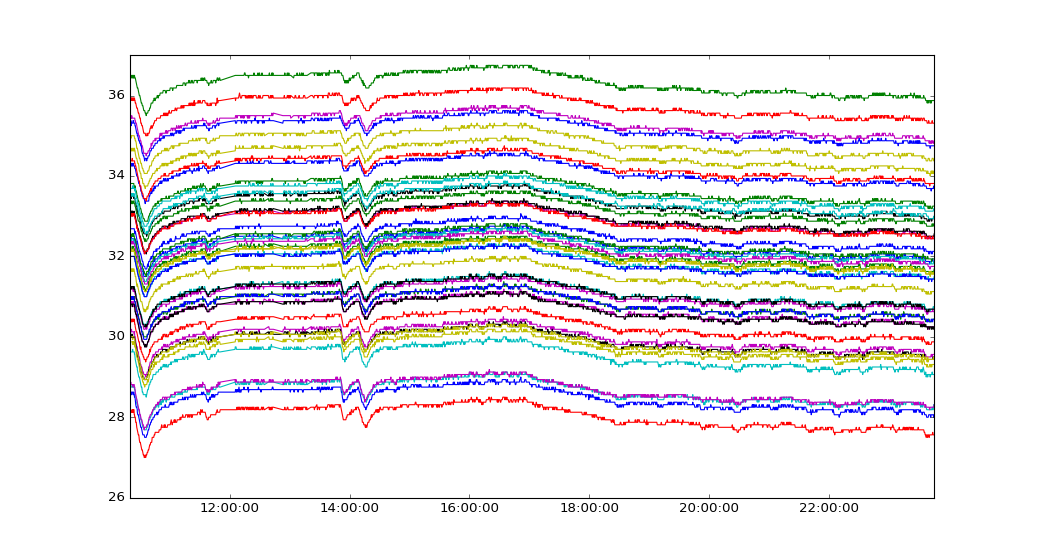

In [30]:
allplots=plt.plot(timelist, data)
lims=plt.ylim(26,37)

<IPython.core.display.Javascript object>


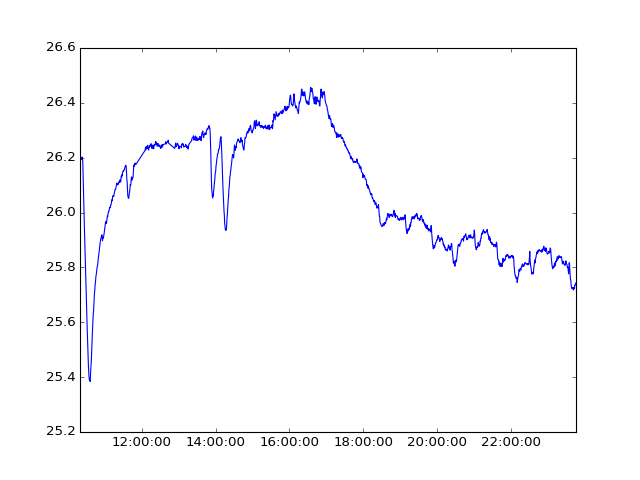

In [28]:
avgplot = plt.plot(timelist, np.mean(data, axis=1))

<IPython.core.display.Javascript object>


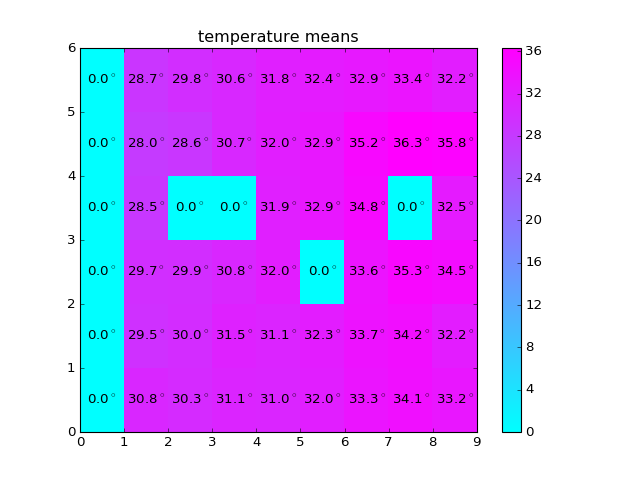

In [29]:
griddata = np.reshape(np.mean(data,axis=0), (6,9))
heatmap = plt.pcolor(griddata, cmap='cool')
plt.colorbar(heatmap)
for y in range(griddata.shape[0]):
    for x in range(griddata.shape[1]):
        val = griddata[y,x]          
        plt.text(x+0.5, y+0.5, '%.1f$^\circ$' % val, horizontalalignment='center', verticalalignment='center')
title=plt.title('temperature means')